In [1]:
# import packages..
import ForwardDiff
using ForwardDiff
using DiffBase

using PyPlot
import Base.convert

# === ForwardDiff v0.3
#     using DiffBase
#     out = DiffBase.HessianResult(x)
#     ForwardDiff.hessian!(out, f, x)
#     v = DiffBase.value(out)
#     g = DiffBase.gradient(out)
#     h = DiffBase.hessian(out)

# import Optim
# using Optim

# === Upgrading from ForwardDiff v0.1 to v0.2
# instead of ForwardDiff.GradientNumber and ForwardDiff.HessianNumber, 
# we will use ForwardDiff.Dual

convert(::Type{Float64}, x::ForwardDiff.Dual) = Float64(x.value)
function convert(::Array{Float64}, x::Array{ForwardDiff.Dual}) 
    y = zeros(size(x)); 
    for i in 1:prod(size(x)) 
        y[i] = convert(Float64, x[i]) 
    end
    return y
end


    write(Base.IO, ForwardDiff.Partials) at /Users/msyoon/.julia/v0.4/ForwardDiff/src/partials.jl:57
is ambiguous with: 
    write(Base.Base64.Base64EncodePipe, AbstractArray{UInt8, 1}) at base64.jl:89.
To fix, define 
    write(Base.Base64.Base64EncodePipe, ForwardDiff.Partials{N<:Any, UInt8})
before the new definition.


convert (generic function with 640 methods)

## Import Data

In [2]:
using MAT
ratdata = matread("J259data.mat")

Dict{ASCIIString,Any} with 1 entry:
  "data" => Dict{ASCIIString,Any}("Rrate"=>59598x1 Array{Float64,2}:…

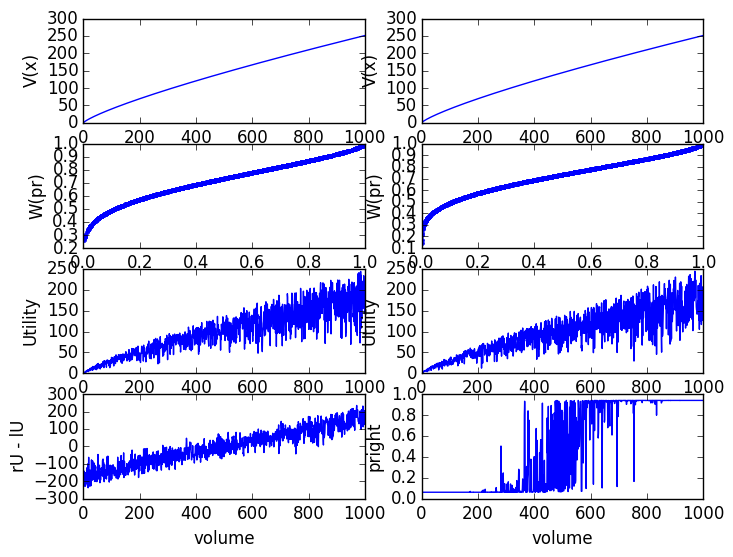

PyObject <matplotlib.text.Text object at 0x319e8e750>

In [3]:
### Just testing

n = 1000
rightprob = rand(n) #ratdata["data"]["RF"]
rightvol = n:-1:1      #ratdata["data"]["Rrate"]
leftprob = rand(n)  #ratdata["data"]["LF"]
leftvol = 1:n       #ratdata["data"]["Lrate"]
wr = rand(n).<0.5   #ratdata["data"]["WR"]

# params=[0.3, 0.2, 8, 20, 0., 0.]
params = [0.8, 0.7, 0.4, 0.09, 0.06, -0.02]

rho = params[1]; alpha = params[2]; beta = params[3];
lambda = params[4]; lapse = params[5]; bias_shift = params[6]; 
    
vL = leftvol.^rho
wL = exp(-beta*(-log(leftprob)).^alpha)
left_util = vL.*wL

vR = rightvol.^rho;
wR = exp(-beta*(-log(rightprob)).^alpha)
right_util = vR.*wR

bias = right_util - left_util
bias = [0; bias[1:end-1]].*bias_shift

pright = lapse + (1-2*lapse)./(1+exp(-lambda.*(right_util-left_util)+bias))

LL = -(sum(log(pright[wr.==1])) + sum(log(1-pright[wr.==0])))

subplot(4,2,1)
plot(leftvol,vL)
xlabel("volume")
ylabel("V(x)")

subplot(4,2,2)
plot(rightvol,vR)
xlabel("volume")
ylabel("V(x)")

subplot(4,2,3)
plot(leftprob,wL,linestyle="none",marker=".")
xlim(0,1)
xlabel("prob")
ylabel("W(pr)")

subplot(4,2,4)
plot(rightprob,wR,linestyle="none",marker=".")
xlim(0,1)
xlabel("prob")
ylabel("W(pr)")

subplot(4,2,5)
plot(leftvol,left_util)
xlabel("volume")
ylabel("Utility")

subplot(4,2,6)
plot(rightvol,right_util)
xlabel("volume")
ylabel("Utility")

subplot(4,2,7)
plot(rightvol,right_util-left_util)
xlabel("volume")
ylabel("rU - lU")

subplot(4,2,8)
plot(rightvol,pright)
xlabel("volume")
ylabel("pright")


In [13]:
"""
Takes params
    rho = params[1]; alpha = params[2]; beta = params[3];
    lambda = params[4]; lapse = params[5]; bias_shift = params[6]; 

Returns the log likelihood 
"""

function Loglike_vec(params::Vector, rightprob, rightvol, leftprob, leftvol, wr)    
    rho = params[1]; alpha = params[2]; beta = params[3];
    lambda = params[4]; lapse = params[5]; bias_shift = params[6]; 
    
    # if the probability is exact 0 or 1 
    # the gradient and hessian would be NaN
    const epsilon = 1e-16
    leftprob[leftprob.== 0] = epsilon 
    leftprob[leftprob.== 1] = 1-epsilon 
    rightprob[rightprob.== 0] = epsilon 
    rightprob[rightprob.== 1] = 1-epsilon 
    
    vL = leftvol.^rho
    wL = exp(-beta*(-log(leftprob)).^alpha)
    left_util = vL.*wL

    vR = rightvol.^rho;
    wR = exp(-beta*(-log(rightprob)).^alpha)
    right_util = vR.*wR

    # how does this bias work!?
    bias = right_util - left_util
    bias = [0; bias[1:end-1]].*bias_shift

    pright = lapse + (1-2*lapse)./(1+exp(-lambda.*(right_util-left_util)+bias))

    likelihoods = zeros(size(leftprob))
    likelihoods[wr.==1] = pright[wr.==1]
    likelihoods[wr.==0] = 1-pright[wr.==0]
    
    LL = sum(log(pright[wr.==1])) + sum(log(1-pright[wr.==0]))
    LL = -LL # for minimization
    
    return LL, likelihoods
end

Loglike_vec (generic function with 1 method)

In [14]:
### =============== testing 1 ================= ####

# Parameters
rho = 0.3; alpha = 0.2; beta = 8.;
lambda = 10.; lapse = 0.; bias_shift = 0.2; 

params = [rho, alpha, beta, lambda, lapse, bias_shift]

@time LL, lls = Loglike_vec(params,ratdata["data"]["RF"],ratdata["data"]["Rrate"],ratdata["data"]["LF"],ratdata["data"]["Lrate"],ratdata["data"]["WR"])

### =========================================== #### 

  0.092225 seconds (20.88 k allocations: 14.788 MB, 12.31% gc time)


(426293.0290119358,
59598x1 Array{Float64,2}:
 4.01882e-8 
 5.64958e-8 
 1.0        
 1.0        
 1.0        
 1.0        
 8.37015e-15
 8.43769e-15
 1.0        
 1.0        
 2.85877e-8 
 1.0        
 1.0        
 ⋮          
 1.0        
 2.9754e-14 
 1.0        
 2.9754e-14 
 2.9754e-14 
 1.0        
 1.0        
 1.0        
 1.24736e-11
 1.0        
 1.0        
 1.0        )

In [12]:
log(lls[14763])
ratdata["data"]["LF"][14763]

0.2

In [7]:
"""
function all_trial(params::Vector, rightprob, rightvol, leftprob, leftvol, wr)

Takes params
    rho = params[1]; 
    alpha = params[2]; beta = params[3];
    lambda = params[4]; lapse = params[5]; bias_shift = params[6]; 

rightprob   vector of the right probability for each trial
leftprob    vector of the left probability for each trial
rightvol    vector of the right volume for each trial
leftvol     vector of the left volume for each trial
wr          vector of the rat choice (1=right, 0=left) for each trial

Returns the log-likelihood / gradient / hessian matrix for given parameter
"""
# === Upgrading from ForwardDiff v0.1 -> v0.2 -> v0.3
# for Retrieving Lower-Order Results
#     # old way
#     answer, results = ForwardDiff.hessian(f, x, AllResults)
#     v = ForwardDiff.value(results)
#     g = ForwardDiff.gradient(results)
#     h = ForwardDiff.hessian(results) # == answer

#     # old v0.2 style
#     out = HessianResult(x)
#     ForwardDiff.hessian!(out, f, x)
#     v = ForwardDiff.value(out)
#     g = ForwardDiff.gradient(out)
#     h = ForwardDiff.hessian(out)

#     # current v0.3 style
#     using DiffBase
#     out = DiffBase.HessianResult(x)
#     ForwardDiff.hessian!(out, f, x)
#     v = DiffBase.value(out)
#     g = DiffBase.gradient(out)
#     h = DiffBase.hessian(out)

function all_trial(params::Vector, rightprob, rightvol, leftprob, leftvol, wr)
    function llikey(params::Vector)
        Loglike_vec(params,rightprob,rightvol,leftprob,leftvol,wr)
    end
    
    result =  DiffBase.HessianResult(params)
    
    ForwardDiff.hessian!(result, llikey, params);
    
    LL     = DiffBase.value(result)
    LLgrad = DiffBase.gradient(result)
    LLHess = DiffBase.hessian(result)

    return LL, LLgrad, LLHess    
    
end

all_trial (generic function with 1 method)

In [8]:
### =============== testing 2 ================= ####

# Parameters
# rho = 0.3; alpha = 0.2; beta = 8.;
# lambda = 10.; lapse = 0.; bias_shift = 0.2; 

# params = [rho, alpha, beta, lambda, lapse, bias_shift]

params = [0.8107, 0.7375, 0.4474, 0.0897, 0.0597, -0.0194]

LL, LLgrad, LLhess = all_trial(params,ratdata["data"]["RF"],ratdata["data"]["Rrate"],ratdata["data"]["LF"],ratdata["data"]["Lrate"],ratdata["data"]["WR"])
### =========================================== #### 

LoadError: MethodError: `extract_gradient!` has no method matching extract_gradient!(::DiffBase.DiffResult{1,ForwardDiff.Dual{6,Float64},Tuple{Array{ForwardDiff.Dual{6,Float64},1}}}, ::Tuple{ForwardDiff.Dual{6,ForwardDiff.Dual{6,Float64}},Array{Float64,2}})[0m
Closest candidates are:
  extract_gradient!(::DiffBase.DiffResult{O,V,D<:Tuple}, [1m[31m::ForwardDiff.Dual{N,T<:Real}[0m)
  extract_gradient!(::DiffBase.DiffResult{O,V,D<:Tuple}, [1m[31m::Real[0m)[0m

In [9]:
imshow(log(abs(LLhess)), interpolation="none", ColorMap("hot"))

2*sqrt(diag(inv(LLhess))) # for the error bar... (inverse hessian matrix = covariance matrix)

LoadError: UndefVarError: LLhess not defined

# The end of Hessain matrix Calculation!
_________________________________
______________________________
## For single trial..

In [ ]:
"""
Takes params
    rho = params[1]; alpha = params[2]; beta = params[3];
    lambda = params[4]; lapse = params[5]; bias_shift = params[6]; 

Returns the log likelihood 
"""

function Loglike(params::Vector, rightprob,rightvol,leftprob,leftvol,wr)
    
    epsilon = 1e-10
    rho = params[1]; alpha = params[2]; beta = params[3];
    lambda = params[4]; lapse = params[5]; bias_shift = params[6]; 
    
    if leftprob == 0 leftprob = epsilon end
    if rightprob == 0 rightprob = epsilon end
    if leftprob == 1 leftprob = 1-epsilon end
    if rightprob == 1 rightprob = 1-epsilon end
      
    vL = leftvol^rho
    wL = exp(-beta*(-log(leftprob))^alpha)
    
    vR = rightvol^rho
    wR = exp(-beta*(-log(rightprob))^alpha)

    right_util = vR*wR
    left_util = vL*wL
    pright = lapse + (1-2*lapse)/(1+exp(-lambda*(right_util-left_util)+bias_shift))
    
    if wr > 0
        LLi = log(pright)
    else
        LLi = log(1-pright)
    end
    
    return LLi
end


In [ ]:
function single_trial(params::Vector, rightprob::Float64, rightvol::Float64, leftprob::Float64, leftvol::Float64, wr::Int)
    function llikey(params::Vector)
        Loglike(params,rightprob,rightvol,leftprob,leftvol,wr)
    end
    
    result =  HessianResult(params)
    
    ForwardDiff.hessian!(result, llikey, params);
    
    LL     = ForwardDiff.value(result)
    LLgrad = ForwardDiff.gradient(result)
    LLHess = ForwardDiff.hessian(result)
   
    return LL, LLgrad, LLHess    
    
end

In [ ]:
# Parameters
rho = 0.3; alpha = 0.2; beta = 8.;
lambda = 10.; lapse = 0.; bias_shift = 0.2; 

params = [rho, alpha, beta, lambda, lapse, bias_shift]

# params = [lambda, rho,alpha, beta]
i = 14763
rightprob = ratdata["data"]["RF"][i]::Float64
rightvol = ratdata["data"]["Rrate"][i]::Float64
leftprob = ratdata["data"]["LF"][i]::Float64
leftvol = ratdata["data"]["Lrate"][i]::Float64
wr = Int(ratdata["data"]["WR"][i])

LL, LLgrad = single_trial(params,rightprob,rightvol,leftprob,leftvol,wr)




In [ ]:
# why nan value ?
zeros(2,2) \ zeros(2)

In [ ]:
function ComputeHess(params::Vector, ratdata)
    
    ntrials = size(ratdata["data"]["RF"],1)
    
    function WrapperLL(params::Vector)
        LL        = 0.

        for i in 1:10#ntrials
            rightprob = ratdata["data"]["RF"][i]
            rightvol = ratdata["data"]["Rrate"][i]
            leftprob = ratdata["data"]["LF"][i]
            leftvol = ratdata["data"]["Lrate"][i]
            wr = ratdata["data"]["WR"][i]

            LLi = Loglike(params,rightprob,rightvol,leftprob,leftvol,wr)
            LL        = LL + LLi;
        end

        LL = -LL
        return LL
    end

    result =  HessianResult(params)
    
    ForwardDiff.hessian!(result, WrapperLL, params);
    
    LL     = ForwardDiff.value(result)
    LLgrad = ForwardDiff.gradient(result)
    LLHess = ForwardDiff.hessian(result)
   
    return LL, LLgrad, LLHess
end

# function ComputeHess(params::Vector, ratdata)
#     rightprob = data["RF"]
#     rightvol = data["Rrate"]
#     leftprob = data["LF"]
#     leftvol = data["Lrate"]
#     wr = data["WR"]



#     function WrapperLL(params::Vector)
#         return Loglike(params,ratdata["data"])
#     end

#     result =  HessianResult(params)
    
#     ForwardDiff.hessian!(result, WrapperLL, params);
    
#     LL     = ForwardDiff.value(result)
#     LLgrad = ForwardDiff.gradient(result)
#     LLHess = ForwardDiff.hessian(result)
   
#     return LL, LLgrad, LLHess
# end

In [ ]:
ComputeHess(params, ratdata)

In [ ]:
leftprob = rand()
rightprob = 1-leftprob
leftvol = 3
rightvol = 4

function answer(p) 
    
    function V(p)
        U(p,rightvol)*W(p[2:3],rightprob)-U(p,leftvol)*W(p[2:3],leftprob)
    end
    
    function U(p,x)
        x^p[1]
    end
    function W(p,x) 
        exp(-p[1]*(-log(x))^p[2])
    end

    x = one(eltype(p))
    p[5] + (1-2*p[5])./(1 + exp(-(V(p[1:3])-p[6]) ./ p[4])) 
    
end
param = rand(6)
result = HessianResult(param)
ForwardDiff.hessian!(result, answer, param);
result

In [ ]:
function U(p)
    x = one(eltype(p))
    x^p[1]
end

In [ ]:
function W(p) 
    x = one(eltype(p))*rand()
    exp(-p[1]*(-log(x))^p[2])
end

x = rand(4)
result = HessianResult(x)
ForwardDiff.hessian!(result, W, x);
result

In [ ]:
function V(p)
    U(p)*W(p[2:3])-U(p)*W(p[2:3])
end
x = rand(4)
result = HessianResult(x)
ForwardDiff.hessian!(result, V, x);
result

In [ ]:
function sig4_2(p) 
    x = one(eltype(p))
    p[1] + p[2]./(1 + exp(-(V(p[5:7])-p[3]) ./ p[4])) 
end
x = rand(7)
result = HessianResult(x)
ForwardDiff.hessian!(result, sig4_2, x);
result

In [ ]:
x = rand(6)

In [ ]:
### Just testing

rightprob = ratdata["data"]["RF"]
rightvol = ratdata["data"]["Rrate"]
leftprob = ratdata["data"]["LF"]
leftvol = ratdata["data"]["Lrate"]
wr = ratdata["data"]["WR"]

params=[0.3, 0.2, 8., 10., 0., 0.2]
# params = [0.8, 0.7, 0.4, 0.09, 0.06, -0.02]

rho = params[1]; alpha = params[2]; beta = params[3];
lambda = params[4]; lapse = params[5]; bias_shift = params[6]; 
    
vL = leftvol.^rho
wL = exp(-beta*(-log(leftprob)).^alpha)
left_util = vL.*wL

vR = rightvol.^rho;
wR = exp(-beta*(-log(rightprob)).^alpha)
right_util = vR.*wR

bias = right_util - left_util
bias = [0; bias[1:end-1]].*bias_shift

pright = lapse + (1-2*lapse)./(1+exp(-lambda.*(right_util-left_util)+bias))

likelihoods = zeros(size(leftprob))
likelihoods[wr.==1] = pright[wr.==1]
likelihoods[wr.==0] = 1-pright[wr.==0]

LL = -(sum(log(pright[wr.==1])) + sum(log(1-pright[wr.==0])))




In [ ]:
idd = 15059
log(likelihoods[idd])
# bias[idd]

In [ ]:
Pkg.status("ForwardDiff")